# Implementación del modelo base

### José Daniel Gómez Cabrera 21429

- Entrenar un modelo inicial con LightGBM utilizando métricas tradicionales como AUC-ROC y F1-score.
- Evaluar el rendimiento inicial en términos de fraude detectado y falsos positivos.


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import optuna

In [29]:
df = pd.read_csv('../data/dataset_feature_engineering.csv', header=0)

In [30]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

## Variable objetivo


In [32]:
fraud_dist = df['is_fraud'].value_counts().rename({0: 'No fraud', 1: 'Fraud'})
fraud_percent = (fraud_dist / fraud_dist.sum()) * 100

fraud_df = pd.DataFrame({
    'Amount': fraud_dist,
    'Percentage': fraud_percent.round(2)
})
fraud_df

,Amount,Percentage
is_fraud,,
No fraud,1842743,99.48
Fraud,9651,0.52


## Modelo


In [33]:
# Modelo 2 
# Optimización de hiperparámetros usando Optuna para LightGBM
# Optuna es un framework de optimización de hiperparámetros que utiliza
# técnicas avanzadas de búsqueda como TPE (Tree-structured Parzen Estimators)

# Definimos la función objetivo para Optuna
def objetivo(trial):
    """
    Función objetivo para optimización de hiperparámetros.
    Recibe un objeto trial de Optuna y retorna la métrica a optimizar (AUC-ROC).
    """
    # Definimos el espacio de búsqueda para los hiperparámetros
    param = {
        'objective': 'binary',  # Objetivo: clasificación binaria
        'metric': 'auc',       # Métrica a optimizar
        'boosting_type': 'gbdt',
        # Sugerimos valores para cada hiperparámetro en rangos específicos
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),           # Número de hojas
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Tasa de aprendizaje
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0), # Fracción de features
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0), # Fracción de datos
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),     # Muestras mínimas por nodo
        'max_depth': trial.suggest_int('max_depth', 5, 30),                      # Profundidad máxima
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),         # Regularización L1
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),         # Regularización L2
    }

    # Creamos los datasets de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Entrenamos el modelo con los parámetros sugeridos
    callbacks = [lgb.early_stopping(stopping_rounds=10)]
    
    model = lgb.train(param,
                     train_data,
                     num_boost_round=100,
                     valid_sets=[valid_data],
                     callbacks=callbacks)

    # Realizamos predicciones
    y_pred_proba = model.predict(X_test)
    
    # Retornamos el AUC-ROC score
    return roc_auc_score(y_test, y_pred_proba)

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')  # Queremos maximizar el AUC-ROC
study.optimize(objetivo, n_trials=50)  # Realizamos 50 pruebas de optimización

# Obtenemos los mejores parámetros
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt'
})

# Entrenamos el modelo final con los mejores parámetros
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

callbacks = [lgb.early_stopping(stopping_rounds=10)]

modelo_optimizado = lgb.train(best_params,
                            train_data,
                            num_boost_round=100,
                            valid_sets=[test_data],
                            callbacks=callbacks)

# Realizamos predicciones con el modelo optimizado
y_pred_proba_opt = modelo_optimizado.predict(X_test)
y_pred_opt = (y_pred_proba_opt > 0.5).astype(int)

# Evaluamos el modelo optimizado
auc_score_opt = roc_auc_score(y_test, y_pred_proba_opt)
f1_opt = f1_score(y_test, y_pred_opt)

# Imprimimos el reporte de clasificación
print("Reporte de Clasificación del Modelo Optimizado:")
print(classification_report(y_test, y_pred_opt))

# Imprimimos los mejores parámetros encontrados
print("\nMejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"{key}: {value}")


[I 2025-05-09 15:38:37,683] A new study created in memory with name: no-name-f99e70a7-d938-4920-8b10-8719b367ab71


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:38:40,283] Trial 0 finished with value: 0.990582685917396 and parameters: {'num_leaves': 51, 'learning_rate': 0.014715692682632307, 'feature_fraction': 0.8337253487072955, 'bagging_fraction': 0.8842128436579582, 'min_child_samples': 23, 'max_depth': 10, 'lambda_l1': 9.519387844375668e-08, 'lambda_l2': 0.01231576567744614}. Best is trial 0 with value: 0.990582685917396.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990583
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:38:43,128] Trial 1 finished with value: 0.9917505440134561 and parameters: {'num_leaves': 59, 'learning_rate': 0.021073414927784685, 'feature_fraction': 0.8116878143787192, 'bagging_fraction': 0.8433129218631671, 'min_child_samples': 61, 'max_depth': 11, 'lambda_l1': 0.00016830148010622427, 'lambda_l2': 1.9612148015632402e-06}. Best is trial 1 with value: 0.9917505440134561.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991751
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993614


[I 2025-05-09 15:38:46,888] Trial 2 finished with value: 0.9936142416753494 and parameters: {'num_leaves': 81, 'learning_rate': 0.036153889035306974, 'feature_fraction': 0.673737086443415, 'bagging_fraction': 0.940974829015256, 'min_child_samples': 99, 'max_depth': 13, 'lambda_l1': 2.244701632382327e-05, 'lambda_l2': 8.003066162847903e-08}. Best is trial 2 with value: 0.9936142416753494.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2025-05-09 15:38:49,372] Trial 3 finished with value: 0.9918837208016963 and parameters: {'num_leaves': 56, 'learning_rate': 0.0540915041083376, 'feature_fraction': 0.71401007991365, 'bagging_fraction': 0.5119314794546541, 'min_child_samples': 7, 'max_depth': 5, 'lambda_l1': 0.0049659730564630975, 'lambda_l2': 0.00021706736563838268}. Best is trial 2 with value: 0.9936142416753494.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.994342


[I 2025-05-09 15:38:52,973] Trial 4 finished with value: 0.9943416409367164 and parameters: {'num_leaves': 60, 'learning_rate': 0.05717303896376501, 'feature_fraction': 0.5452927427150227, 'bagging_fraction': 0.7117275173764982, 'min_child_samples': 13, 'max_depth': 11, 'lambda_l1': 0.0009998925086521309, 'lambda_l2': 1.5311161665815864}. Best is trial 4 with value: 0.9943416409367164.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:38:53,944] Trial 5 finished with value: 0.9869058441836953 and parameters: {'num_leaves': 33, 'learning_rate': 0.010668117273570128, 'feature_fraction': 0.7850494307521448, 'bagging_fraction': 0.5527019444211878, 'min_child_samples': 81, 'max_depth': 28, 'lambda_l1': 6.330174788695863e-05, 'lambda_l2': 4.494681592048745e-05}. Best is trial 4 with value: 0.9943416409367164.


Early stopping, best iteration is:
[27]	valid_0's auc: 0.986906
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:38:56,683] Trial 6 finished with value: 0.9905766017021703 and parameters: {'num_leaves': 57, 'learning_rate': 0.013468292258362895, 'feature_fraction': 0.8390575343336613, 'bagging_fraction': 0.8291121734279252, 'min_child_samples': 51, 'max_depth': 23, 'lambda_l1': 2.458392288559255, 'lambda_l2': 0.0002309017207862739}. Best is trial 4 with value: 0.9943416409367164.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.990577
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99206


[I 2025-05-09 15:38:59,810] Trial 7 finished with value: 0.9920603540867652 and parameters: {'num_leaves': 79, 'learning_rate': 0.01830211802952535, 'feature_fraction': 0.8051180743471702, 'bagging_fraction': 0.8323739151045486, 'min_child_samples': 90, 'max_depth': 22, 'lambda_l1': 8.884367892205969e-06, 'lambda_l2': 0.0006657981655135899}. Best is trial 4 with value: 0.9943416409367164.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.98967


[I 2025-05-09 15:39:03,349] Trial 8 finished with value: 0.9896695277428251 and parameters: {'num_leaves': 78, 'learning_rate': 0.07075107005065082, 'feature_fraction': 0.9070247805509085, 'bagging_fraction': 0.7971608332625003, 'min_child_samples': 83, 'max_depth': 19, 'lambda_l1': 0.00022259224569062794, 'lambda_l2': 1.1003815307255681e-07}. Best is trial 4 with value: 0.9943416409367164.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:39:05,835] Trial 9 finished with value: 0.991344873857212 and parameters: {'num_leaves': 28, 'learning_rate': 0.03760531148246607, 'feature_fraction': 0.6286149356918911, 'bagging_fraction': 0.5294181720144697, 'min_child_samples': 49, 'max_depth': 5, 'lambda_l1': 2.4875212069515152e-05, 'lambda_l2': 5.326568052200489e-08}. Best is trial 4 with value: 0.9943416409367164.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991345
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996024


[I 2025-05-09 15:39:10,577] Trial 10 finished with value: 0.9960244342750378 and parameters: {'num_leaves': 98, 'learning_rate': 0.0951508485930548, 'feature_fraction': 0.5161572564653886, 'bagging_fraction': 0.6617718893284814, 'min_child_samples': 28, 'max_depth': 16, 'lambda_l1': 0.021748341217420915, 'lambda_l2': 7.759909111883483}. Best is trial 10 with value: 0.9960244342750378.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.995896


[I 2025-05-09 15:39:15,305] Trial 11 finished with value: 0.995895966883351 and parameters: {'num_leaves': 100, 'learning_rate': 0.08343091318250098, 'feature_fraction': 0.5133298270606683, 'bagging_fraction': 0.662828449944298, 'min_child_samples': 25, 'max_depth': 15, 'lambda_l1': 0.0412876567702112, 'lambda_l2': 5.235380981130612}. Best is trial 10 with value: 0.9960244342750378.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996489


[I 2025-05-09 15:39:20,231] Trial 12 finished with value: 0.9964889006810679 and parameters: {'num_leaves': 100, 'learning_rate': 0.09610954578698412, 'feature_fraction': 0.5047578980485751, 'bagging_fraction': 0.6661491747239299, 'min_child_samples': 31, 'max_depth': 17, 'lambda_l1': 0.13800990649514966, 'lambda_l2': 3.4512470223811507}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.995279


[I 2025-05-09 15:39:24,698] Trial 13 finished with value: 0.9952794367789031 and parameters: {'num_leaves': 100, 'learning_rate': 0.09454807246139613, 'feature_fraction': 0.5810425094824638, 'bagging_fraction': 0.6350073782175067, 'min_child_samples': 36, 'max_depth': 18, 'lambda_l1': 0.7247004898466299, 'lambda_l2': 0.12168068874953607}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.994497


[I 2025-05-09 15:39:28,723] Trial 14 finished with value: 0.9944970392130157 and parameters: {'num_leaves': 89, 'learning_rate': 0.054148496105118536, 'feature_fraction': 0.5021494912199834, 'bagging_fraction': 0.6337031955147752, 'min_child_samples': 34, 'max_depth': 22, 'lambda_l1': 0.08752334225150972, 'lambda_l2': 0.13646951858650963}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.996125


[I 2025-05-09 15:39:33,124] Trial 15 finished with value: 0.9961254775424669 and parameters: {'num_leaves': 90, 'learning_rate': 0.09839647604455608, 'feature_fraction': 0.6051032433373382, 'bagging_fraction': 0.7308336785970666, 'min_child_samples': 65, 'max_depth': 30, 'lambda_l1': 0.038514230109867084, 'lambda_l2': 9.7118428452051}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993489


[I 2025-05-09 15:39:37,072] Trial 16 finished with value: 0.9934894409299244 and parameters: {'num_leaves': 88, 'learning_rate': 0.029001495335877606, 'feature_fraction': 0.609389665117498, 'bagging_fraction': 0.7466592218164004, 'min_child_samples': 66, 'max_depth': 30, 'lambda_l1': 0.318438885829461, 'lambda_l2': 0.3480999382413178}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993712


[I 2025-05-09 15:39:40,667] Trial 17 finished with value: 0.9937123282837237 and parameters: {'num_leaves': 70, 'learning_rate': 0.06752013358758772, 'feature_fraction': 0.6651582647681809, 'bagging_fraction': 0.7234879099986297, 'min_child_samples': 66, 'max_depth': 25, 'lambda_l1': 8.885510822275263, 'lambda_l2': 0.009492430332670426}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.992631


[I 2025-05-09 15:39:43,540] Trial 18 finished with value: 0.9926309858107903 and parameters: {'num_leaves': 41, 'learning_rate': 0.04053150896694359, 'feature_fraction': 0.5647528394931791, 'bagging_fraction': 0.5944389444140367, 'min_child_samples': 40, 'max_depth': 27, 'lambda_l1': 0.003703142168081887, 'lambda_l2': 0.010027720407806926}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:39:46,406] Trial 19 finished with value: 0.9910949840643164 and parameters: {'num_leaves': 68, 'learning_rate': 0.02612838614643238, 'feature_fraction': 0.9844675576223657, 'bagging_fraction': 0.7796215411132316, 'min_child_samples': 59, 'max_depth': 20, 'lambda_l1': 1.8864688593160603e-06, 'lambda_l2': 0.8644149338456493}. Best is trial 12 with value: 0.9964889006810679.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991095
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.9949

[I 2025-05-09 15:39:50,368] Trial 20 finished with value: 0.9949906178733557 and parameters: {'num_leaves': 90, 'learning_rate': 0.07278878081109957, 'feature_fraction': 0.7267823928576482, 'bagging_fraction': 0.7002206144580332, 'min_child_samples': 74, 'max_depth': 8, 'lambda_l1': 0.2450549784612127, 'lambda_l2': 0.04110484442871089}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996033


[I 2025-05-09 15:39:55,108] Trial 21 finished with value: 0.9960329054922635 and parameters: {'num_leaves': 94, 'learning_rate': 0.09899133791927907, 'feature_fraction': 0.5410760140100974, 'bagging_fraction': 0.6705974644591316, 'min_child_samples': 45, 'max_depth': 16, 'lambda_l1': 0.017158374330470984, 'lambda_l2': 9.106516086444701}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.996149


[I 2025-05-09 15:39:59,637] Trial 22 finished with value: 0.9961490849644581 and parameters: {'num_leaves': 92, 'learning_rate': 0.09931303279688562, 'feature_fraction': 0.6073182077138787, 'bagging_fraction': 0.5992403387538501, 'min_child_samples': 46, 'max_depth': 15, 'lambda_l1': 0.008428964873438097, 'lambda_l2': 8.266522949336931}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995773


[I 2025-05-09 15:40:03,702] Trial 23 finished with value: 0.9957732835948807 and parameters: {'num_leaves': 86, 'learning_rate': 0.0785198462789757, 'feature_fraction': 0.6199792227092996, 'bagging_fraction': 0.5978941226485592, 'min_child_samples': 55, 'max_depth': 14, 'lambda_l1': 0.0019429124024607748, 'lambda_l2': 1.3157772085112023}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993645


[I 2025-05-09 15:40:07,238] Trial 24 finished with value: 0.993644833648594 and parameters: {'num_leaves': 71, 'learning_rate': 0.04897442958758681, 'feature_fraction': 0.6726413976981291, 'bagging_fraction': 0.5869770834006196, 'min_child_samples': 17, 'max_depth': 20, 'lambda_l1': 2.4116826001942044, 'lambda_l2': 2.3529580266024746}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.995268


[I 2025-05-09 15:40:11,341] Trial 25 finished with value: 0.9952680686471432 and parameters: {'num_leaves': 93, 'learning_rate': 0.06379204700293219, 'feature_fraction': 0.5886723741334576, 'bagging_fraction': 0.7740870394609105, 'min_child_samples': 43, 'max_depth': 17, 'lambda_l1': 0.013273500984581842, 'lambda_l2': 0.359054851253346}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.994859


[I 2025-05-09 15:40:15,268] Trial 26 finished with value: 0.994859430021881 and parameters: {'num_leaves': 83, 'learning_rate': 0.08599382941325384, 'feature_fraction': 0.5569231929294132, 'bagging_fraction': 0.5613885693923684, 'min_child_samples': 73, 'max_depth': 24, 'lambda_l1': 0.1437840040390628, 'lambda_l2': 0.04880973681526888}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993763


[I 2025-05-09 15:40:18,610] Trial 27 finished with value: 0.9937631889328561 and parameters: {'num_leaves': 74, 'learning_rate': 0.04476841537108308, 'feature_fraction': 0.6342544972383154, 'bagging_fraction': 0.6253949846429759, 'min_child_samples': 33, 'max_depth': 12, 'lambda_l1': 0.0005154376026164032, 'lambda_l2': 0.0021278754638077266}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995012


[I 2025-05-09 15:40:22,531] Trial 28 finished with value: 0.9950122037075064 and parameters: {'num_leaves': 95, 'learning_rate': 0.08331804397818461, 'feature_fraction': 0.7086038102584417, 'bagging_fraction': 0.682705710836011, 'min_child_samples': 49, 'max_depth': 8, 'lambda_l1': 0.8442557519637213, 'lambda_l2': 9.87403331720195}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.978001


[I 2025-05-09 15:40:24,797] Trial 29 finished with value: 0.9780007497464908 and parameters: {'num_leaves': 20, 'learning_rate': 0.06907947620050386, 'feature_fraction': 0.751512102158632, 'bagging_fraction': 0.9983707647560612, 'min_child_samples': 16, 'max_depth': 14, 'lambda_l1': 3.1826705096329324e-07, 'lambda_l2': 7.634859075583655e-06}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.994484


[I 2025-05-09 15:40:28,213] Trial 30 finished with value: 0.9944837384154924 and parameters: {'num_leaves': 65, 'learning_rate': 0.06159871237179514, 'feature_fraction': 0.5995913419209806, 'bagging_fraction': 0.9096616257305665, 'min_child_samples': 27, 'max_depth': 9, 'lambda_l1': 0.006492800457258045, 'lambda_l2': 0.43986446525745587}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996178


[I 2025-05-09 15:40:32,778] Trial 31 finished with value: 0.9961778026270522 and parameters: {'num_leaves': 93, 'learning_rate': 0.09862012602358661, 'feature_fraction': 0.5346736187128103, 'bagging_fraction': 0.6774683669117891, 'min_child_samples': 43, 'max_depth': 17, 'lambda_l1': 0.04142294508758082, 'lambda_l2': 2.9669844976849915}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995877


[I 2025-05-09 15:40:37,489] Trial 32 finished with value: 0.9958771140136555 and parameters: {'num_leaves': 93, 'learning_rate': 0.09955139468241003, 'feature_fraction': 0.53628584948677, 'bagging_fraction': 0.7299705290534896, 'min_child_samples': 58, 'max_depth': 18, 'lambda_l1': 0.0513992949110262, 'lambda_l2': 1.9582360974880335}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995875


[I 2025-05-09 15:40:42,418] Trial 33 finished with value: 0.9958751771796696 and parameters: {'num_leaves': 84, 'learning_rate': 0.08279217588011793, 'feature_fraction': 0.6535336541692368, 'bagging_fraction': 0.6268125382751945, 'min_child_samples': 42, 'max_depth': 20, 'lambda_l1': 0.06546962801317714, 'lambda_l2': 2.9119326041153415}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993667


[I 2025-05-09 15:40:46,113] Trial 34 finished with value: 0.9936670891771359 and parameters: {'num_leaves': 76, 'learning_rate': 0.07717304282646911, 'feature_fraction': 0.5756314568965835, 'bagging_fraction': 0.6932644322727781, 'min_child_samples': 64, 'max_depth': 16, 'lambda_l1': 0.0013782536611463736, 'lambda_l2': 1.169957932861665e-08}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.994346


[I 2025-05-09 15:40:49,392] Trial 35 finished with value: 0.9943464010466416 and parameters: {'num_leaves': 49, 'learning_rate': 0.08855324791632874, 'feature_fraction': 0.5005638676475253, 'bagging_fraction': 0.7565253530050874, 'min_child_samples': 32, 'max_depth': 12, 'lambda_l1': 0.010084043346620079, 'lambda_l2': 0.1141435066785863}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995171


[I 2025-05-09 15:40:53,628] Trial 36 finished with value: 0.9951710546613204 and parameters: {'num_leaves': 95, 'learning_rate': 0.06051969337078964, 'feature_fraction': 0.541210620955986, 'bagging_fraction': 0.6555982444515767, 'min_child_samples': 73, 'max_depth': 14, 'lambda_l1': 0.54485931289462, 'lambda_l2': 0.5127753667543594}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.992655


[I 2025-05-09 15:40:57,231] Trial 37 finished with value: 0.9926554727276977 and parameters: {'num_leaves': 86, 'learning_rate': 0.021608359801857137, 'feature_fraction': 0.7027342323758805, 'bagging_fraction': 0.7144755806923602, 'min_child_samples': 22, 'max_depth': 26, 'lambda_l1': 1.1883489631068017e-08, 'lambda_l2': 0.02404797662024925}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993907


[I 2025-05-09 15:41:01,035] Trial 38 finished with value: 0.9939065132584108 and parameters: {'num_leaves': 82, 'learning_rate': 0.04893604063999824, 'feature_fraction': 0.636816767801988, 'bagging_fraction': 0.8080006468034421, 'min_child_samples': 55, 'max_depth': 30, 'lambda_l1': 2.3292811198685817, 'lambda_l2': 2.7862979553616873}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds


[I 2025-05-09 15:41:01,819] Trial 39 finished with value: 0.9681227303838253 and parameters: {'num_leaves': 98, 'learning_rate': 0.07548970110652839, 'feature_fraction': 0.857896703558727, 'bagging_fraction': 0.8596250795856012, 'min_child_samples': 7, 'max_depth': 22, 'lambda_l1': 0.00039471781859971915, 'lambda_l2': 0.0018899871336691598}. Best is trial 12 with value: 0.9964889006810679.


Early stopping, best iteration is:
[6]	valid_0's auc: 0.968123
[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.992427


[I 2025-05-09 15:41:05,360] Trial 40 finished with value: 0.9924266595511221 and parameters: {'num_leaves': 90, 'learning_rate': 0.09155465207203446, 'feature_fraction': 0.5268436777624205, 'bagging_fraction': 0.5640933892827383, 'min_child_samples': 39, 'max_depth': 19, 'lambda_l1': 7.797984296133803e-05, 'lambda_l2': 6.187343623648342e-06}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.996098


[I 2025-05-09 15:41:10,003] Trial 41 finished with value: 0.9960978380600544 and parameters: {'num_leaves': 93, 'learning_rate': 0.09338797907346791, 'feature_fraction': 0.5525597480068278, 'bagging_fraction': 0.6731916712842743, 'min_child_samples': 46, 'max_depth': 16, 'lambda_l1': 0.0031276584937159147, 'lambda_l2': 7.6711460302861925}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996156


[I 2025-05-09 15:41:14,353] Trial 42 finished with value: 0.9961556915968851 and parameters: {'num_leaves': 93, 'learning_rate': 0.08827297633841445, 'feature_fraction': 0.563021999652398, 'bagging_fraction': 0.6151798119549478, 'min_child_samples': 47, 'max_depth': 17, 'lambda_l1': 0.002733726316212186, 'lambda_l2': 1.0961676028178513}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995884


[I 2025-05-09 15:41:18,296] Trial 43 finished with value: 0.9958844056239557 and parameters: {'num_leaves': 80, 'learning_rate': 0.09978942416805872, 'feature_fraction': 0.584925334631883, 'bagging_fraction': 0.5236616311687429, 'min_child_samples': 51, 'max_depth': 17, 'lambda_l1': 0.03428946637384819, 'lambda_l2': 0.6881898723753492}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991661


[I 2025-05-09 15:41:22,371] Trial 44 finished with value: 0.9916613906002846 and parameters: {'num_leaves': 97, 'learning_rate': 0.014817415381041671, 'feature_fraction': 0.6065036555336877, 'bagging_fraction': 0.619677241379381, 'min_child_samples': 37, 'max_depth': 13, 'lambda_l1': 0.0008334369440401216, 'lambda_l2': 3.7801309459989416}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995452


[I 2025-05-09 15:41:26,695] Trial 45 finished with value: 0.9954518288977292 and parameters: {'num_leaves': 91, 'learning_rate': 0.08762327734819976, 'feature_fraction': 0.5691700133652597, 'bagging_fraction': 0.6521807269085447, 'min_child_samples': 98, 'max_depth': 19, 'lambda_l1': 0.09937396771217184, 'lambda_l2': 0.17463826388983034}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.995776


[I 2025-05-09 15:41:31,348] Trial 46 finished with value: 0.9957761721729704 and parameters: {'num_leaves': 100, 'learning_rate': 0.07516776901179892, 'feature_fraction': 0.5234442001707057, 'bagging_fraction': 0.6075884128407738, 'min_child_samples': 48, 'max_depth': 15, 'lambda_l1': 0.01044936655458403, 'lambda_l2': 1.3239937016697514}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.995255


[I 2025-05-09 15:41:35,414] Trial 47 finished with value: 0.9952547358932482 and parameters: {'num_leaves': 87, 'learning_rate': 0.06670679971440988, 'feature_fraction': 0.6423806882823886, 'bagging_fraction': 0.7404201637232349, 'min_child_samples': 31, 'max_depth': 21, 'lambda_l1': 0.004577157365701861, 'lambda_l2': 3.972967354717197}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996187


[I 2025-05-09 15:41:39,879] Trial 48 finished with value: 0.9961867101182172 and parameters: {'num_leaves': 96, 'learning_rate': 0.08112838786710479, 'feature_fraction': 0.500953735226365, 'bagging_fraction': 0.5770761833557665, 'min_child_samples': 54, 'max_depth': 18, 'lambda_l1': 0.00015489788778535617, 'lambda_l2': 1.160975515170678}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993924


[I 2025-05-09 15:41:43,086] Trial 49 finished with value: 0.9939239253125802 and parameters: {'num_leaves': 52, 'learning_rate': 0.05634328507817271, 'feature_fraction': 0.5039486218592448, 'bagging_fraction': 0.5443488799592457, 'min_child_samples': 54, 'max_depth': 18, 'lambda_l1': 7.828702502841702e-05, 'lambda_l2': 0.18904844878297483}. Best is trial 12 with value: 0.9964889006810679.


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005195 -> initscore=-5.254922
[LightGBM] [Info] Start training from score -5.254922
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.996489
Reporte de Clasificación del Modelo Optimizado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.89      0.64      0.74      1953

    accuracy                           1.00    370479
   macro avg       0.94      0.82 

In [34]:
# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Create a DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Score': [accuracy, precision, recall, f1, auc_score]
})

# Format scores as percentages
metrics_df['Score'] = metrics_df['Score'].map('{:.2%}'.format)

# Display metrics in a styled table
print("\nModel Performance Metrics:")
print("------------------------")
print(metrics_df.to_string(index=False))



Model Performance Metrics:
------------------------
   Metric  Score
 Accuracy 99.69%
Precision 79.77%
   Recall 55.71%
 F1 Score 65.60%
  AUC-ROC 99.21%


### Análisis de Métricas de Rendimiento del Modelo

- **Accuracy (99.69%)**: Indica que el modelo acierta en el 99.69% de todas las predicciones, tanto fraudulentas como legítimas. Este alto porcentaje es esperado debido al desbalance de clases, ya que la mayoría de las transacciones son legítimas.

- **Precision (79.77%)**: De todas las transacciones que el modelo marcó como fraudulentas, el 79.77% realmente lo eran. Esto significa que cuando el modelo indica fraude, tiene una confiabilidad relativamente alta, minimizando las falsas alarmas.

- **Recall (55.71%)**: El modelo detecta el 55.71% de todos los fraudes reales. Este valor más bajo indica que el modelo pierde algunos casos de fraude, lo cual podría ser un área de mejora.

- **F1 Score (65.60%)**: Es la media armónica entre precisión y recall. Un valor de 65.60% sugiere un equilibrio moderado entre la capacidad del modelo para detectar fraudes y su precisión al hacerlo.

- **AUC-ROC (99.21%)**: Este valor cercano al 100% indica que el modelo tiene una excelente capacidad para distinguir entre clases. Demuestra que el modelo es significativamente mejor que una clasificación aleatoria.

En conjunto, estas métricas sugieren que el modelo es bastante efectivo, especialmente considerando el desbalance inherente en los datos de fraude. Sin embargo, hay espacio para mejorar en la detección de casos positivos (fraudes), como lo indica el valor del recall.


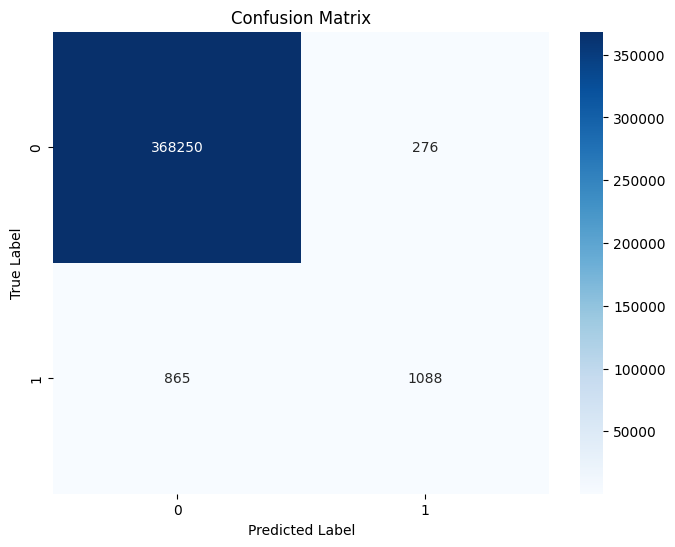

In [35]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión nos muestra el rendimiento detallado del modelo:

- Verdaderos Negativos (368250): El número de transacciones no fraudulentas correctamente identificadas
- Falsos Positivos (276): Transacciones legítimas incorrectamente marcadas como fraude
- Falsos Negativos (865): Casos de fraude que el modelo no detectó
- Verdaderos Positivos (1088): Casos de fraude correctamente identificados
  Observaciones importantes:
- El modelo tiene una alta precisión en la identificación de transacciones legítimas
- Hay un número relativamente bajo de falsos positivos, lo cual es importante para no molestar a clientes legítimos
- El número de falsos negativos (865) podría ser un área de mejora, aunque representa un pequeño porcentaje del total
- La diagonal principal muestra un buen rendimiento general del modelo
  En general, la matriz de confusión indica que el modelo es efectivo en la clasificación de transacciones, con un sesgo hacia minimizar los falsos positivos.


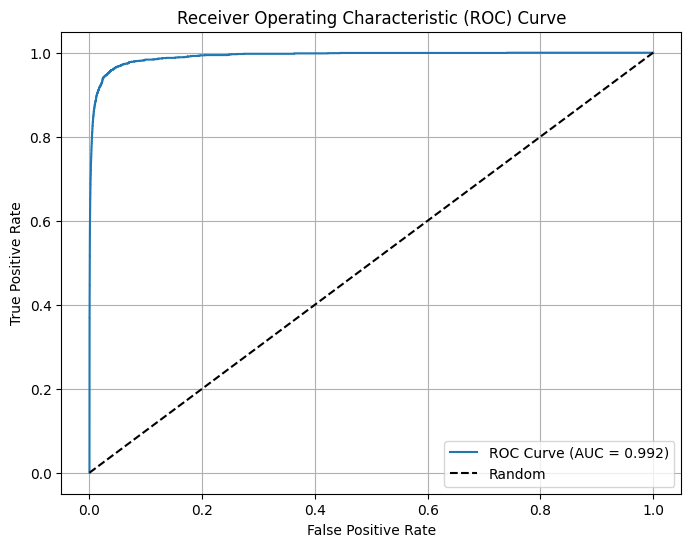

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


### Análisis de la Curva ROC

La curva ROC (Receiver Operating Characteristic) que se muestra en el gráfico representa el rendimiento de nuestro modelo de clasificación para detectar fraudes. Algunos puntos importantes a destacar:

- El área bajo la curva (AUC) es de 0.992, lo cual es excelente ya que está muy cerca del valor ideal de 1.0
- La curva se eleva rápidamente hacia el punto (0,1), lo que indica que el modelo tiene una alta tasa de verdaderos positivos mientras mantiene una baja tasa de falsos positivos
- Hay una clara separación entre la curva del modelo (línea azul) y la línea diagonal punteada que representa el rendimiento aleatorio
- Esta curva sugiere que el modelo es muy efectivo en distinguir entre transacciones fraudulentas y legítimas
- El rendimiento es consistentemente bueno a través de diferentes umbrales de clasificación

En resumen, esta curva ROC demuestra que nuestro modelo tiene un poder predictivo muy fuerte para la detección de fraudes en transacciones.
